# Pig Detection YOLOv8 Project

Scratch implementation of a YOLOv8-style detector with advanced data augmentation and training utilities.

## Project Setup

Configure experiment paths, seeding, and other environment defaults for training YOLOv8-style models from scratch.

In [1]:
import os
import json
import math
import random
import itertools
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
from PIL import Image, ImageOps
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeRemainingColumn, TimeElapsedColumn, MofNCompleteColumn

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision.ops import nms


In [2]:
# Experiment metadata
EXPERIMENT_NAME = "pig_detection_yolov8"
RUN_ID = datetime.now().strftime("%Y%m%d-%H%M%S")
OUTPUT_DIR = Path("artifacts") / EXPERIMENT_NAME / RUN_ID
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def _prepare_run_directory(base_dir: Path = OUTPUT_DIR) -> Path:
    base_dir.mkdir(parents=True, exist_ok=True)
    return base_dir


RUN_DIR = _prepare_run_directory(OUTPUT_DIR)

DATA_ROOT = Path("../../../taica-cvpdl-2025-hw-1/")
ANNOTATIONS_PATH = DATA_ROOT / "train/gt.txt"
IMAGES_DIR = DATA_ROOT / "train/img"
TEST_IMAGES_DIR = DATA_ROOT / "test/img"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


In [3]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


set_seed(42)


## Data Pipeline

In [4]:
@dataclass
class BoxLabel:
    cls: int
    xyxy: np.ndarray  # [x1, y1, x2, y2]

def ltwh_to_xyxy(box: Tuple[float, float, float, float]) -> np.ndarray:
    x, y, w, h = box
    return np.array([x, y, x + w, y + h], dtype=np.float32)

def xyxy_to_ltwh(box: np.ndarray) -> np.ndarray:
    x1, y1, x2, y2 = box
    return np.array([x1, y1, x2 - x1, y2 - y1], dtype=np.float32)

def xyxy_to_ltwh_tensor(boxes: torch.Tensor) -> torch.Tensor:
    if boxes.numel() == 0:
        return boxes.new_zeros((0, 4))
    out = torch.zeros_like(boxes)
    out[:, 0] = boxes[:, 0]
    out[:, 1] = boxes[:, 1]
    out[:, 2] = boxes[:, 2] - boxes[:, 0]
    out[:, 3] = boxes[:, 3] - boxes[:, 1]
    return out

def ltwh_to_xyxy_tensor(boxes: torch.Tensor) -> torch.Tensor:
    if boxes.numel() == 0:
        return boxes.new_zeros((0, 4))
    out = torch.zeros_like(boxes)
    out[:, 0] = boxes[:, 0]
    out[:, 1] = boxes[:, 1]
    out[:, 2] = boxes[:, 0] + boxes[:, 2]
    out[:, 3] = boxes[:, 1] + boxes[:, 3]
    return out

def parse_annotations_txt(annotations_path: Path, images_dir: Path) -> List[Dict]:
    annotations = {}
    with open(annotations_path, "r") as fp:
        for line in fp:
            parts = line.strip().split(",")
            if len(parts) < 5:
                continue
            frame_id = int(parts[0])
            box = tuple(float(v) for v in parts[1:5])
            annotations.setdefault(frame_id, []).append(box)

    records: List[Dict] = []
    skipped = 0
    for frame_id in sorted(annotations.keys()):
        image_path = images_dir / f"{frame_id:08d}.jpg"
        if not image_path.exists():
            skipped += 1
            continue
        labels = [BoxLabel(0, ltwh_to_xyxy(b)) for b in annotations[frame_id]]
        records.append({"image_id": frame_id, "image_path": image_path, "labels": labels})

    if skipped:
        print(f"Warning: skipped {skipped} annotation entries without matching images.")
    return records

def resize_and_pad(img: Image.Image, labels: List[BoxLabel], new_size: int = 640, fill: int = 114) -> Tuple[Image.Image, List[BoxLabel]]:
    w, h = img.size
    r = min(new_size / h, new_size / w)
    nh, nw = int(round(h * r)), int(round(w * r))
    img_resized = img.resize((nw, nh), Image.BILINEAR)
    canvas = Image.new("RGB", (new_size, new_size), (fill, fill, fill))
    offset_x = (new_size - nw) // 2
    offset_y = (new_size - nh) // 2
    canvas.paste(img_resized, (offset_x, offset_y))

    adjusted = []
    for lb in labels:
        x1, y1, x2, y2 = lb.xyxy
        x1 = x1 * r + offset_x
        x2 = x2 * r + offset_x
        y1 = y1 * r + offset_y
        y2 = y2 * r + offset_y
        adjusted.append(BoxLabel(lb.cls, np.array([x1, y1, x2, y2], dtype=np.float32)))
    return canvas, adjusted

def random_hflip_pil(img: Image.Image, labels: List[BoxLabel], p: float = 0.5) -> Tuple[Image.Image, List[BoxLabel]]:
    if random.random() >= p:
        return img, labels
    img = ImageOps.mirror(img)
    w, _ = img.size
    flipped = []
    for lb in labels:
        x1, y1, x2, y2 = lb.xyxy
        flipped.append(BoxLabel(lb.cls, np.array([w - x2, y1, w - x1, y2], dtype=np.float32)))
    return img, flipped

def mosaic_4(samples: List[Tuple[Image.Image, List[BoxLabel]]], out_size: int = 640, fill: int = 114) -> Tuple[Image.Image, List[BoxLabel]]:
    s = out_size
    canvas = Image.new("RGB", (s * 2, s * 2), (fill, fill, fill))
    yc, xc = [int(random.uniform(s // 2, s * 1.5)) for _ in range(2)]
    new_labels: List[BoxLabel] = []

    for i, (img, labels) in enumerate(samples):
        img, labels = resize_and_pad(img, labels, s, fill)
        w, h = img.size

        if i == 0:  # top-left
            x1a = max(xc - w, 0)
            y1a = max(yc - h, 0)
            x2a = xc
            y2a = yc
            x1b = w - (x2a - x1a)
            y1b = h - (y2a - y1a)
            x2b = w
            y2b = h
        elif i == 1:  # top-right
            x1a = xc
            y1a = max(yc - h, 0)
            x2a = min(xc + w, s * 2)
            y2a = yc
            x1b = 0
            y1b = h - (y2a - y1a)
            x2b = x2a - x1a
            y2b = h
        elif i == 2:  # bottom-left
            x1a = max(xc - w, 0)
            y1a = yc
            x2a = xc
            y2a = min(yc + h, s * 2)
            x1b = w - (x2a - x1a)
            y1b = 0
            x2b = w
            y2b = y2a - y1a
        else:  # bottom-right
            x1a = xc
            y1a = yc
            x2a = min(xc + w, s * 2)
            y2a = min(yc + h, s * 2)
            x1b = 0
            y1b = 0
            x2b = x2a - x1a
            y2b = y2a - y1a

        if x1a >= x2a or y1a >= y2a:
            continue
        img_crop = img.crop((x1b, y1b, x2b, y2b))
        canvas.paste(img_crop, (x1a, y1a, x2a, y2a))

        dx, dy = x1a - x1b, y1a - y1b
        for lb in labels:
            x1, y1, x2, y2 = lb.xyxy
            x1 = np.clip(x1 + dx, 0, s * 2 - 1)
            y1 = np.clip(y1 + dy, 0, s * 2 - 1)
            x2 = np.clip(x2 + dx, 0, s * 2 - 1)
            y2 = np.clip(y2 + dy, 0, s * 2 - 1)
            if x2 > x1 and y2 > y1:
                new_labels.append(BoxLabel(lb.cls, np.array([x1, y1, x2, y2], dtype=np.float32)))

    x1 = xc - s // 2
    y1 = yc - s // 2
    x2 = x1 + s
    y2 = y1 + s
    canvas = canvas.crop((x1, y1, x2, y2))

    cropped_labels = []
    for lb in new_labels:
        x1_, y1_, x2_, y2_ = lb.xyxy - np.array([x1, y1, x1, y1], dtype=np.float32)
        x1_, y1_ = np.clip([x1_, y1_], 0, s - 1)
        x2_, y2_ = np.clip([x2_, y2_], 0, s - 1)
        if x2_ > x1_ and y2_ > y1_:
            cropped_labels.append(BoxLabel(lb.cls, np.array([x1_, y1_, x2_, y2_], dtype=np.float32)))
    return canvas, cropped_labels

def mixup(img1: Image.Image, labels1: List[BoxLabel], img2: Image.Image, labels2: List[BoxLabel], alpha: float = 0.2) -> Tuple[Image.Image, List[BoxLabel]]:
    lam = np.random.beta(alpha, alpha)
    img = Image.blend(img1, img2, 1 - lam)
    return img, labels1 + labels2

def clip_boxes_ltwh_(boxes: torch.Tensor, height: int, width: int) -> torch.Tensor:
    if boxes.numel() == 0:
        return boxes
    boxes[:, 0] = boxes[:, 0].clamp_(min=0.0, max=float(width - 1))
    boxes[:, 1] = boxes[:, 1].clamp_(min=0.0, max=float(height - 1))
    boxes[:, 2] = boxes[:, 2].clamp_(min=1.0)
    boxes[:, 3] = boxes[:, 3].clamp_(min=1.0)
    max_width = (width - boxes[:, 0]).clamp(min=1.0)
    max_height = (height - boxes[:, 1]).clamp(min=1.0)
    boxes[:, 2] = torch.minimum(boxes[:, 2], max_width)
    boxes[:, 3] = torch.minimum(boxes[:, 3], max_height)
    return boxes

class ComposeAugmentations:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image: torch.Tensor, target: dict):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class RandomHorizontalFlip:
    def __init__(self, prob: float = 0.5):
        self.prob = prob

    def __call__(self, image: torch.Tensor, target: dict):
        if torch.rand(1).item() < self.prob:
            image = torch.flip(image, dims=[2])
            width = image.shape[2]
            boxes = target["boxes"]
            if boxes.numel() > 0:
                boxes[:, 0] = width - (boxes[:, 0] + boxes[:, 2])
                clip_boxes_ltwh_(boxes, image.shape[1], width)
                target["boxes"] = boxes
        return image, target

class RandomScaleResize:
    def __init__(self, min_size_choices=(512, 640, 768), max_size: int | None = 1024):
        self.min_size_choices = min_size_choices
        self.max_size = max_size

    def __call__(self, image: torch.Tensor, target: dict):
        h, w = image.shape[1:]
        short_side = min(h, w)
        choice = float(self.min_size_choices[torch.randint(0, len(self.min_size_choices), (1,)).item()])
        scale = choice / short_side
        new_h = int(round(h * scale))
        new_w = int(round(w * scale))
        if self.max_size is not None:
            max_side = max(new_h, new_w)
            if max_side > self.max_size:
                scale = self.max_size / max_side
                new_h = int(round(new_h * scale))
                new_w = int(round(new_w * scale))

        image = F.interpolate(image.unsqueeze(0), size=(new_h, new_w), mode="bilinear", align_corners=False).squeeze(0)
        boxes = target["boxes"]
        if boxes.numel() > 0:
            scale_w = new_w / w
            scale_h = new_h / h
            boxes[:, 0] *= scale_w
            boxes[:, 2] *= scale_w
            boxes[:, 1] *= scale_h
            boxes[:, 3] *= scale_h
            clip_boxes_ltwh_(boxes, new_h, new_w)
            target["boxes"] = boxes
        target["image_size"] = torch.tensor([new_h, new_w], dtype=torch.int64)
        return image, target

class RandomColorJitter:
    def __init__(self, brightness: float = 0.2, contrast: float = 0.2):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, image: torch.Tensor, target: dict):
        if self.brightness > 0:
            factor = 1.0 + torch.empty(1).uniform_(-self.brightness, self.brightness).item()
            image = image * factor
        if self.contrast > 0:
            mean = image.mean(dim=(1, 2), keepdim=True)
            factor = 1.0 + torch.empty(1).uniform_(-self.contrast, self.contrast).item()
            image = (image - mean) * factor + mean
        image = image.clamp(0.0, 1.0)
        return image, target

class NormalizeImage:
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, image: torch.Tensor, target: dict):
        image = (image - self.mean.to(image.device)) / self.std.to(image.device)
        return image, target

class PadToStride:
    def __init__(self, stride: int = 32, value: float = 0.0):
        self.stride = stride
        self.value = value

    def __call__(self, image: torch.Tensor, target: dict):
        h, w = image.shape[1:]
        pad_h = (self.stride - h % self.stride) % self.stride
        pad_w = (self.stride - w % self.stride) % self.stride
        if pad_h > 0 or pad_w > 0:
            image = F.pad(image, (0, pad_w, 0, pad_h), value=self.value)
        target["image_size"] = torch.tensor([image.shape[1], image.shape[2]], dtype=torch.int64)
        return image, target

def build_augmentation_pipeline(train: bool = True):
    if train:
        return ComposeAugmentations([
            RandomScaleResize(),
            RandomHorizontalFlip(0.5),
            RandomColorJitter(0.2, 0.2),
            NormalizeImage(),
            PadToStride(stride=32),
        ])
    return ComposeAugmentations([
        RandomScaleResize(min_size_choices=(640,), max_size=1024),
        NormalizeImage(),
        PadToStride(stride=32),
    ])

class PigDetectionYOLODataset(Dataset):
    def __init__(
        self,
        records: List[Dict],
        imgsz: int = 640,
        mosaic_p: float = 0.5,
        mixup_p: float = 0.15,
        hflip_p: float = 0.5,
        train: bool = True,
        transforms: ComposeAugmentations | None = None,
    ):
        self.records = records
        self.imgsz = imgsz
        self.mosaic_p = mosaic_p
        self.mixup_p = mixup_p
        self.hflip_p = hflip_p
        self.train = train
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.records)

    def load_record(self, idx: int) -> Tuple[Image.Image, List[BoxLabel]]:
        record = self.records[idx]
        img = Image.open(record["image_path"]).convert("RGB")
        labels = [BoxLabel(lb.cls, lb.xyxy.copy()) for lb in record["labels"]]
        return img, labels

    def _apply_mosaic(self, idx: int) -> Tuple[Image.Image, List[BoxLabel]]:
        if len(self.records) >= 4:
            extra = random.sample(range(len(self.records)), 3)
        else:
            extra = [random.randrange(len(self.records)) for _ in range(3)]
        indices = [idx] + extra
        samples = [self.load_record(i) for i in indices]
        return mosaic_4(samples, out_size=self.imgsz)

    def __getitem__(self, idx: int):
        if self.train and random.random() < self.mosaic_p:
            img, labels = self._apply_mosaic(idx)
        else:
            img, labels = self.load_record(idx)
            img, labels = resize_and_pad(img, labels, new_size=self.imgsz)

        if self.train and random.random() < self.mixup_p:
            j = random.randrange(len(self.records))
            img2, labels2 = self.load_record(j)
            img2, labels2 = resize_and_pad(img2, labels2, new_size=self.imgsz)
            img, labels = mixup(img, labels, img2, labels2)

        img_np = np.array(img, dtype=np.uint8, copy=True)
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0
        if labels:
            boxes_xyxy_np = np.stack([lb.xyxy for lb in labels], axis=0).astype(np.float32)
            boxes_xyxy = torch.from_numpy(boxes_xyxy_np)
        else:
            boxes_xyxy = torch.zeros((0, 4), dtype=torch.float32)
        boxes_ltwh = xyxy_to_ltwh_tensor(boxes_xyxy)
        target = {
            "boxes": boxes_ltwh.clone(),
            "labels": torch.tensor([lb.cls for lb in labels], dtype=torch.long) if labels else torch.zeros((0,), dtype=torch.long),
            "image_size": torch.tensor([img_tensor.shape[1], img_tensor.shape[2]], dtype=torch.int64),
        }

        pad_transform = PadToStride(stride=32)
        if self.transforms is not None:
            img_tensor, target = self.transforms(img_tensor, target)
        else:
            img_tensor, target = pad_transform(img_tensor, target)

        boxes_xyxy_out = ltwh_to_xyxy_tensor(target["boxes"])
        labels_out = target["labels"]
        if boxes_xyxy_out.numel() == 0:
            target_tensor = torch.zeros((0, 5), dtype=torch.float32)
        else:
            target_tensor = torch.cat([
                labels_out.float().unsqueeze(1),
                boxes_xyxy_out.float(),
            ], dim=1)
        return img_tensor, target_tensor


def collate_yolo(batch: List[Tuple[torch.Tensor, torch.Tensor]]):
    images, targets = zip(*batch)
    max_h = max(img.shape[1] for img in images)
    max_w = max(img.shape[2] for img in images)
    padded_images = []
    for img in images:
        pad_h = max_h - img.shape[1]
        pad_w = max_w - img.shape[2]
        if pad_h > 0 or pad_w > 0:
            img = F.pad(img, (0, pad_w, 0, pad_h), value=0.0)
        padded_images.append(img)
    return padded_images, list(targets)


In [5]:
records = parse_annotations_txt(ANNOTATIONS_PATH, IMAGES_DIR)
if not records:
    raise RuntimeError("No records found. Please verify dataset paths and annotation format.")

random.Random(42).shuffle(records)
VAL_RATIO = 0.2
val_size = max(1, int(len(records) * VAL_RATIO))
train_records = records[val_size:]
val_records = records[:val_size]

print(f"Total samples: {len(records)} | train={len(train_records)} | val={len(val_records)}")

IMG_SIZE = 640
MOSAIC_P = 0.5
MIXUP_P = 0.15
HFLIP_P = 0.5

train_transforms = build_augmentation_pipeline(train=True)
val_transforms = build_augmentation_pipeline(train=False)

train_dataset = PigDetectionYOLODataset(
    train_records,
    imgsz=IMG_SIZE,
    mosaic_p=MOSAIC_P,
    mixup_p=MIXUP_P,
    hflip_p=HFLIP_P,
    train=True,
    transforms=train_transforms,
)

val_dataset = PigDetectionYOLODataset(
    val_records,
    imgsz=IMG_SIZE,
    mosaic_p=0.0,
    mixup_p=0.0,
    hflip_p=0.0,
    train=False,
    transforms=val_transforms,
)

BATCH_SIZE = 4
NUM_WORKERS = 0  # torch.multiprocessing spawn cannot pickle notebook-defined classes


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_yolo,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_yolo,
)


Total samples: 1266 | train=1013 | val=253


Dataset and dataloader configuration is defined in the previous cell.

## Model Definition

In [6]:
def autopad(k: int, p: int | None = None, d: int = 1) -> int:
    if d > 1:
        k = d * (k - 1) + 1
    return k // 2 if p is None else p


class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Conv(nn.Module):
    def __init__(self, c1, c2, k=3, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2, eps=1e-3, momentum=0.03)
        self.act = SiLU() if act else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class Bottleneck(nn.Module):
    def __init__(self, c1, c2, shortcut=True, e=0.5):
        super().__init__()
        c_ = int(c2 * e)
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c2, 3, 1)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        y = self.cv2(self.cv1(x))
        return x + y if self.add else y


class C2f(nn.Module):
    def __init__(self, c1, c2, n=3, shortcut=True, e=0.5):
        super().__init__()
        c_ = int(c2 * e)
        self.cv1 = Conv(c1, 2 * c_, 1, 1)
        self.m = nn.ModuleList(Bottleneck(c_, c_, shortcut, e=1.0) for _ in range(n))
        self.cv2 = Conv((2 + n) * c_, c2, 1, 1)

    def forward(self, x):
        y = self.cv1(x)
        y1, y2 = torch.chunk(y, 2, dim=1)
        outs = [y1, y2]
        for block in self.m:
            y2 = block(y2)
            outs.append(y2)
        return self.cv2(torch.cat(outs, dim=1))


class SPPF(nn.Module):
    def __init__(self, c1, c2, k=5):
        super().__init__()
        c_ = c1 // 2
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.k = k

    def forward(self, x):
        x = self.cv1(x)
        y1 = F.max_pool2d(x, self.k, stride=1, padding=self.k // 2)
        y2 = F.max_pool2d(y1, self.k, stride=1, padding=self.k // 2)
        y3 = F.max_pool2d(y2, self.k, stride=1, padding=self.k // 2)
        return self.cv2(torch.cat([x, y1, y2, y3], 1))


class YOLOv8Backbone(nn.Module):
    def __init__(self, c_in=3, width=1.0, depth=1.0):
        super().__init__()
        ch = lambda x: int(x * width)
        n = lambda x: max(round(x * depth), 1)

        self.stem = Conv(c_in, ch(64), 3, 2)
        self.p1 = Conv(ch(64), ch(128), 3, 2)
        self.c2 = C2f(ch(128), ch(128), n=n(3))
        self.p2 = Conv(ch(128), ch(256), 3, 2)
        self.c3 = C2f(ch(256), ch(256), n=n(6))
        self.p3 = Conv(ch(256), ch(512), 3, 2)
        self.c4 = C2f(ch(512), ch(512), n=n(6))
        self.p4 = Conv(ch(512), ch(512), 3, 2)
        self.c5 = C2f(ch(512), ch(512), n=n(3))
        self.sppf = SPPF(ch(512), ch(512))

    def forward(self, x):
        x = self.stem(x)
        x = self.p1(x)
        x = self.c2(x)
        p3 = self.p2(x)
        p3 = self.c3(p3)
        p4 = self.p3(p3)
        p4 = self.c4(p4)
        p5 = self.p4(p4)
        p5 = self.c5(p5)
        p5 = self.sppf(p5)
        return p3, p4, p5


class YOLOv8PAN(nn.Module):
    def __init__(self, ch_in=(256, 512, 512), ch_out=256):
        super().__init__()
        c3, c4, c5 = ch_in
        self.cv5 = Conv(c5, ch_out, 1, 1)
        self.cv4 = Conv(c4, ch_out, 1, 1)
        self.cv3 = Conv(c3, ch_out, 1, 1)

        self.ups5 = nn.Upsample(scale_factor=2, mode="nearest")
        self.c2f4 = C2f(ch_out * 2, ch_out, n=3, shortcut=False)
        self.ups4 = nn.Upsample(scale_factor=2, mode="nearest")
        self.c2f3 = C2f(ch_out * 2, ch_out, n=3, shortcut=False)

        self.down3 = Conv(ch_out, ch_out, 3, 2)
        self.c2f4d = C2f(ch_out * 2, ch_out, n=3, shortcut=False)
        self.down4 = Conv(ch_out, ch_out, 3, 2)
        self.c2f5d = C2f(ch_out * 2, ch_out, n=3, shortcut=False)

    def forward(self, p3, p4, p5):
        p5 = self.cv5(p5)
        p4_in = self.cv4(p4)
        p5_up = F.interpolate(self.ups5(p5), size=p4_in.shape[-2:], mode="nearest")
        p4 = self.c2f4(torch.cat([p4_in, p5_up], dim=1))

        p3_in = self.cv3(p3)
        p4_up = F.interpolate(self.ups4(p4), size=p3_in.shape[-2:], mode="nearest")
        p3 = self.c2f3(torch.cat([p3_in, p4_up], dim=1))

        down3 = self.down3(p3)
        p4_resized = F.interpolate(p4, size=down3.shape[-2:], mode="nearest")
        n4 = self.c2f4d(torch.cat([down3, p4_resized], dim=1))

        down4 = self.down4(n4)
        p5_resized = F.interpolate(p5, size=down4.shape[-2:], mode="nearest")
        n5 = self.c2f5d(torch.cat([down4, p5_resized], dim=1))
        return p3, n4, n5


class YOLOv8Head(nn.Module):
    def __init__(self, nc: int, ch: int = 256, strides: Tuple[int, ...] = (8, 16, 32)):
        super().__init__()
        self.nc = nc
        self.strides = strides
        self.stems = nn.ModuleList([Conv(ch, ch, 3, 1) for _ in strides])
        self.cls = nn.ModuleList([nn.Conv2d(ch, nc, 1) for _ in strides])
        self.obj = nn.ModuleList([nn.Conv2d(ch, 1, 1) for _ in strides])
        self.box = nn.ModuleList([nn.Conv2d(ch, 4, 1) for _ in strides])

        for m in itertools.chain(self.cls, self.obj, self.box):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, feats: List[torch.Tensor]):
        outputs = []
        grids = []
        for feat, stem, cls_layer, obj_layer, box_layer, stride in zip(
            feats, self.stems, self.cls, self.obj, self.box, self.strides
        ):
            x = stem(feat)
            b, c, h, w = x.shape
            cls_logits = cls_layer(x).permute(0, 2, 3, 1).contiguous().view(b, -1, self.nc)
            obj_logits = obj_layer(x).permute(0, 2, 3, 1).contiguous().view(b, -1, 1)
            box_reg = box_layer(x).permute(0, 2, 3, 1).contiguous().view(b, -1, 4)

            yv, xv = torch.meshgrid(
                torch.arange(h, device=x.device),
                torch.arange(w, device=x.device),
                indexing="ij",
            )
            grid = torch.stack((xv, yv), -1).view(-1, 2).float()
            grids.append((grid, stride, (h, w)))
            outputs.append((cls_logits, obj_logits, box_reg))

        cls_out = torch.cat([o[0] for o in outputs], dim=1)
        obj_out = torch.cat([o[1] for o in outputs], dim=1)
        box_out = torch.cat([o[2] for o in outputs], dim=1)
        return cls_out, obj_out, box_out, grids

    @torch.no_grad()
    def decode(self, cls, obj, box, grids, conf_thr: float = 0.25, iou_thr: float = 0.5) -> List[Dict[str, np.ndarray]]:
        batch_size = cls.shape[0]
        scores = obj.sigmoid() * cls.sigmoid().max(-1, keepdim=True).values
        decoded = []
        base_grids = []
        base_strides = []
        for grid, stride, _ in grids:
            base_grids.append(grid + 0.5)
            base_strides.append(torch.full((grid.shape[0], 1), stride, device=cls.device))
        grid_xy = torch.cat(base_grids, dim=0)
        stride_tensor = torch.cat(base_strides, dim=0)

        for b in range(batch_size):
            score_b = scores[b].squeeze(-1)
            cls_b = cls[b].sigmoid()
            obj_b = obj[b].sigmoid().squeeze(-1)
            box_b = box[b]

            keep = score_b > conf_thr
            if keep.sum() == 0:
                decoded.append({"boxes": np.zeros((0, 4), dtype=np.float32), "scores": np.zeros((0,), dtype=np.float32), "labels": np.zeros((0,), dtype=np.int64)})
                continue

            grid_keep = grid_xy[keep]
            stride_keep = stride_tensor[keep]
            box_keep = box_b[keep]
            cls_keep = cls_b[keep]
            obj_keep = obj_b[keep]

            cxcy = (grid_keep + box_keep[:, :2]) * stride_keep
            wh = box_keep[:, 2:].exp() * stride_keep
            xyxy = torch.cat([cxcy - wh * 0.5, cxcy + wh * 0.5], dim=1)
            scores_keep, labels = cls_keep.max(dim=1)
            scores_keep = scores_keep * obj_keep

            if xyxy.numel() == 0:
                decoded.append({"boxes": np.zeros((0, 4), dtype=np.float32), "scores": np.zeros((0,), dtype=np.float32), "labels": np.zeros((0,), dtype=np.int64)})
                continue

            keep_idx = nms(xyxy, scores_keep, iou_thr)
            xyxy = xyxy[keep_idx]
            scores_keep = scores_keep[keep_idx]
            labels = labels[keep_idx]

            decoded.append(
                {
                    "boxes": xyxy.cpu().numpy(),
                    "scores": scores_keep.cpu().numpy(),
                    "labels": labels.cpu().numpy(),
                }
            )
        return decoded


class YOLOv8(nn.Module):
    def __init__(self, num_classes: int = 1, width: float = 1.0, depth: float = 1.0):
        super().__init__()
        self.backbone = YOLOv8Backbone(width=width, depth=depth)
        ch_in = (int(256 * width), int(512 * width), int(512 * width))
        self.neck = YOLOv8PAN(ch_in=ch_in, ch_out=int(256 * width))
        self.head = YOLOv8Head(nc=num_classes, ch=int(256 * width))

    def forward(self, x):
        p3, p4, p5 = self.backbone(x)
        feats = self.neck(p3, p4, p5)
        return self.head(list(feats))


def build_model(num_classes: int = 1, width: float = 0.5, depth: float = 0.5) -> YOLOv8:
    model = YOLOv8(num_classes=num_classes, width=width, depth=depth)
    return model.to(DEVICE)


model = build_model(num_classes=1, width=0.5, depth=0.5)
print(model)


YOLOv8(
  (backbone): YOLOv8Backbone(
    (stem): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (p1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (c2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (m): ModuleList(
        (0-1): 2 x Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            

In [7]:
def box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return boxes1.new_zeros((boxes1.size(0), boxes2.size(0)))
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[..., 0] * wh[..., 1]
    union = area1[:, None] + area2 - inter
    return inter / union.clamp(min=1e-6)


def generalized_box_iou(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    xa1, ya1, xa2, ya2 = pred.unbind(1)
    xb1, yb1, xb2, yb2 = target.unbind(1)

    inter_x1 = torch.maximum(xa1, xb1)
    inter_y1 = torch.maximum(ya1, yb1)
    inter_x2 = torch.minimum(xa2, xb2)
    inter_y2 = torch.minimum(ya2, yb2)
    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    inter_area = inter_w * inter_h

    area_pred = (xa2 - xa1).clamp(min=0) * (ya2 - ya1).clamp(min=0)
    area_target = (xb2 - xb1).clamp(min=0) * (yb2 - yb1).clamp(min=0)
    union = area_pred + area_target - inter_area
    iou = inter_area / union.clamp(min=1e-6)

    enclose_x1 = torch.minimum(xa1, xb1)
    enclose_y1 = torch.minimum(ya1, yb1)
    enclose_x2 = torch.maximum(xa2, xb2)
    enclose_y2 = torch.maximum(ya2, yb2)
    enclose_w = (enclose_x2 - enclose_x1).clamp(min=0)
    enclose_h = (enclose_y2 - enclose_y1).clamp(min=0)
    enclose_area = enclose_w * enclose_h
    giou = iou - (enclose_area - union) / enclose_area.clamp(min=1e-6)
    return giou


class SimpleYOLOLoss(nn.Module):
    def __init__(self, num_classes: int, strides: Tuple[int, ...] = (8, 16, 32)):
        super().__init__()
        self.num_classes = num_classes
        self.strides = list(strides)
        self.bce = nn.BCEWithLogitsLoss(reduction="mean")

    def forward(self, cls_preds, obj_preds, box_preds, grids, targets: List[torch.Tensor]):
        device = cls_preds.device
        batch_size, num_points, _ = cls_preds.shape

        cls_target = torch.zeros_like(cls_preds)
        obj_target = torch.zeros_like(obj_preds)
        box_target = torch.zeros_like(box_preds)
        box_target_xyxy = torch.zeros_like(box_preds)

        grid_xy_list = []
        stride_list = []
        level_meta = []
        offset = 0
        for grid, stride, (h, w) in grids:
            grid_xy_list.append((grid + 0.5).to(device))
            stride_list.append(torch.full((grid.shape[0], 1), stride, device=device))
            level_meta.append((offset, stride, h, w))
            offset += grid.shape[0]

        grid_xy = torch.cat(grid_xy_list, dim=0).unsqueeze(0).repeat(batch_size, 1, 1)
        stride_tensor = torch.cat(stride_list, dim=0).unsqueeze(0).repeat(batch_size, 1, 1)

        for b, target in enumerate(targets):
            if target.numel() == 0:
                continue
            target = target.to(device)
            for lb in target:
                cls_id = int(lb[0].item())
                x1, y1, x2, y2 = lb[1:].tolist()
                cx = 0.5 * (x1 + x2)
                cy = 0.5 * (y1 + y2)
                w = max(x2 - x1, 1.0)
                h = max(y2 - y1, 1.0)
                size = max(w, h)
                if size <= 64:
                    assign_strides = [self.strides[0]]
                elif size <= 128:
                    assign_strides = [self.strides[1]]
                else:
                    assign_strides = [self.strides[2]]
                for stride in assign_strides:
                    level_idx = self.strides.index(stride)
                    offset, s, gh, gw = level_meta[level_idx]
                    gx = int(cx / stride)
                    gy = int(cy / stride)
                    if gx < 0 or gy < 0 or gx >= gw or gy >= gh:
                        continue
                    idx = offset + gy * gw + gx
                    obj_target[b, idx, 0] = 1.0
                    cls_target[b, idx, cls_id] = 1.0
                    delta_x = (cx / stride) - (gx + 0.5)
                    delta_y = (cy / stride) - (gy + 0.5)
                    delta_w = math.log(w / stride)
                    delta_h = math.log(h / stride)
                    box_target[b, idx] = torch.tensor([delta_x, delta_y, delta_w, delta_h], device=device)
                    box_target_xyxy[b, idx] = torch.tensor([x1, y1, x2, y2], device=device)

        pos_mask = obj_target.squeeze(-1) > 0
        loss_obj = self.bce(obj_preds, obj_target)

        if pos_mask.any():
            cls_loss = self.bce(cls_preds[pos_mask], cls_target[pos_mask])
            box_loss = F.smooth_l1_loss(box_preds[pos_mask], box_target[pos_mask])

            grid_pos = grid_xy[pos_mask]
            stride_pos = stride_tensor[pos_mask]
            box_pos = box_preds[pos_mask]
            pred_cxcy = (grid_pos + box_pos[:, :2]) * stride_pos
            pred_wh = box_pos[:, 2:].exp() * stride_pos
            pred_xyxy = torch.cat([pred_cxcy - pred_wh * 0.5, pred_cxcy + pred_wh * 0.5], dim=1)
            target_xyxy = box_target_xyxy[pos_mask]
            giou = generalized_box_iou(pred_xyxy, target_xyxy)
            giou_loss = (1.0 - giou).mean()
        else:
            cls_loss = torch.tensor(0.0, device=device)
            box_loss = torch.tensor(0.0, device=device)
            giou_loss = torch.tensor(0.0, device=device)

        total_loss = loss_obj + cls_loss + box_loss + giou_loss
        return total_loss, {
            "loss_obj": float(loss_obj.detach().cpu()),
            "loss_cls": float(cls_loss.detach().cpu()),
            "loss_box": float(box_loss.detach().cpu()),
            "loss_giou": float(giou_loss.detach().cpu()),
        }


def compute_map_metrics(detections: List[Dict[str, np.ndarray]], targets: List[torch.Tensor], iou_thresholds=None):
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
    ap_sums = np.zeros_like(iou_thresholds, dtype=np.float64)
    iou_accumulator: List[float] = []
    num_images = 0

    for det, tgt in zip(detections, targets):
        gt = tgt.numpy()
        boxes_gt = torch.from_numpy(gt[:, 1:]).float() if gt.size else torch.zeros((0, 4))
        boxes_pred = torch.from_numpy(det["boxes"]).float() if det["boxes"].size else torch.zeros((0, 4))
        scores = torch.from_numpy(det["scores"]).float() if det["scores"].size else torch.zeros((0,))

        if boxes_gt.numel() == 0 and boxes_pred.numel() == 0:
            continue
        num_images += 1

        if boxes_pred.numel() == 0 or boxes_gt.numel() == 0:
            continue

        order = torch.argsort(scores, descending=True)
        boxes_pred = boxes_pred[order]
        scores = scores[order]
        iou_matrix = box_iou(boxes_pred, boxes_gt)

        for idx, thr in enumerate(iou_thresholds):
            matched = torch.zeros(boxes_gt.size(0), dtype=torch.bool)
            matched_ious = []
            for pred_idx in range(boxes_pred.size(0)):
                ious = iou_matrix[pred_idx]
                max_iou, max_idx = ious.max(dim=0)
                if max_iou >= thr and not matched[max_idx]:
                    matched[max_idx] = True
                    matched_ious.append(max_iou.item())
            tp = float(len(matched_ious))
            fp = float(boxes_pred.size(0) - tp)
            precision = tp / (tp + fp + 1e-6) if (tp + fp) > 0 else 0.0
            ap_sums[idx] += precision
            if abs(float(thr) - 0.5) < 1e-6 and matched_ious:
                iou_accumulator.extend(matched_ious)

    metrics = {}
    if num_images > 0:
        metrics["mAP@0.5:0.95"] = float((ap_sums / num_images).mean())
        for thr, ap in zip(iou_thresholds, ap_sums):
            metrics[f"AP@{thr:.2f}"] = float(ap / num_images)
    else:
        metrics["mAP@0.5:0.95"] = 0.0
        for thr in iou_thresholds:
            metrics[f"AP@{thr:.2f}"] = 0.0
    metrics["IoU_mean"] = float(np.mean(iou_accumulator)) if iou_accumulator else 0.0
    return metrics


## Optimization

In [8]:
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 5e-4
NUM_EPOCHS = 30
GRAD_CLIP = 1.0
CONF_THRESHOLD = 0.25
NMS_IOU_THRESHOLD = 0.5

console = Console()

model = build_model(num_classes=1, width=0.5, depth=0.5)
loss_fn = SimpleYOLOLoss(num_classes=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


Parameters: 4.22M


/tmp/ipykernel_63958/4058437105.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [9]:
def _create_progress(task_name: str, total: int) -> Progress:
    return Progress(
        "{task.description}",
        BarColumn(bar_width=24),
        MofNCompleteColumn(),
        TimeElapsedColumn(),
        TimeRemainingColumn(),
        console=console,
        transient=True,
    )


## Training Loop

In [10]:
def to_device_list(tensors: List[torch.Tensor], device: torch.device) -> List[torch.Tensor]:
    return [t.to(device, non_blocking=True) for t in tensors]


def train_one_epoch(model, loss_fn, dataloader, optimizer, scaler, device, epoch: int, log_interval: int = 10):
    model.train()
    running_loss = 0.0
    loss_terms = {"loss_obj": 0.0, "loss_cls": 0.0, "loss_box": 0.0, "loss_giou": 0.0}
    batches = 0
    with _create_progress(f"Train E{epoch}", len(dataloader)) as progress:
        task = progress.add_task(f"Train E{epoch}", total=len(dataloader))
        for step, (images, targets) in enumerate(dataloader, start=1):
            images = to_device_list(images, device)
            targets = to_device_list(targets, device)
            batch = torch.stack(images)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda", enabled=scaler.is_enabled()):
                cls_preds, obj_preds, box_preds, grids = model(batch)
                loss, loss_dict = loss_fn(cls_preds, obj_preds, box_preds, grids, targets)

            scaler.scale(loss).backward()
            if GRAD_CLIP is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()

            running_loss += float(loss.detach().cpu())
            for k in loss_terms:
                loss_terms[k] += loss_dict.get(k, 0.0)
            batches += 1
            avg_loss = running_loss / max(1, batches)
            progress.update(task, advance=1, description=f"Train E{epoch} loss {avg_loss:.4f}")

    mean_losses = {k: v / max(1, batches) for k, v in loss_terms.items()}
    final_loss = running_loss / max(1, batches)
    console.print(f"[train] Epoch {epoch}: loss={final_loss:.4f}")
    return final_loss, mean_losses


@torch.no_grad()
def evaluate(model, loss_fn, dataloader, device, conf_thr: float = CONF_THRESHOLD, epoch: int | None = None):
    model.eval()
    eval_loss = 0.0
    batches = 0
    loss_terms = {"loss_obj": 0.0, "loss_cls": 0.0, "loss_box": 0.0, "loss_giou": 0.0}
    metric_accumulator: Dict[str, float] = {}
    tag = epoch if epoch is not None else "-"
    with _create_progress(f"Val E{tag}", len(dataloader)) as progress:
        task = progress.add_task(f"Val E{tag}", total=len(dataloader))
        for step, (images, targets) in enumerate(dataloader, start=1):
            images = to_device_list(images, device)
            targets_device = to_device_list(targets, device)
            batch = torch.stack(images)

            cls_preds, obj_preds, box_preds, grids = model(batch)
            loss, loss_dict = loss_fn(cls_preds, obj_preds, box_preds, grids, targets_device)
            eval_loss += float(loss.detach().cpu())
            for k in loss_terms:
                loss_terms[k] += loss_dict.get(k, 0.0)
            batches += 1
            progress.update(task, advance=1, description=f"Val E{tag} loss {eval_loss / batches:.4f}")

            decoded = model.head.decode(cls_preds, obj_preds, box_preds, grids, conf_thr=conf_thr, iou_thr=NMS_IOU_THRESHOLD)
            metrics = compute_map_metrics(decoded, [t.cpu() for t in targets])
            for k, v in metrics.items():
                metric_accumulator[k] = metric_accumulator.get(k, 0.0) + v

    eval_loss /= max(1, batches)
    mean_losses = {k: v / max(1, batches) for k, v in loss_terms.items()}
    aggregated_metrics = {k: v / max(1, batches) for k, v in metric_accumulator.items()}
    console.print(f"[val] Epoch {tag}: loss={eval_loss:.4f}")
    return eval_loss, mean_losses, aggregated_metrics


In [11]:
def save_checkpoint(model, optimizer, epoch, best_metric=None):
    checkpoint = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "best_metric": best_metric,
    }
    RUN_DIR.mkdir(parents=True, exist_ok=True)
    ckpt_path = RUN_DIR / f"checkpoint_epoch_{epoch:03d}.pth"
    torch.save(checkpoint, ckpt_path)
    return ckpt_path

def load_checkpoint(model, optimizer, checkpoint_path: Path):
    state = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(state["model_state"])
    optimizer.load_state_dict(state["optimizer_state"])
    return state


In [12]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_terms": [],
    "val_terms": [],
    "val_metrics": [],
}

best_metric = None
no_improve_epochs = 0
patience = 8

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_terms = train_one_epoch(model, loss_fn, train_loader, optimizer, scaler, DEVICE, epoch)
    val_loss, val_terms, val_metrics = evaluate(model, loss_fn, val_loader, DEVICE, conf_thr=CONF_THRESHOLD, epoch=epoch)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_terms"].append(train_terms)
    history["val_terms"].append(val_terms)
    history["val_metrics"].append(val_metrics)

    metric_str = ", ".join(f"{k}={v:.4f}" for k, v in val_metrics.items())
    print(f"Epoch {epoch:03d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, {metric_str}")

    current_metric = val_metrics.get("mAP@0.5:0.95", 0.0)
    if best_metric is None or current_metric > best_metric:
        best_metric = current_metric
        no_improve_epochs = 0
        best_path = RUN_DIR / "best.pth"
        torch.save(
            {
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "epoch": epoch,
                "best_metric": best_metric,
            },
            best_path,
        )
        print(f"Saved new best checkpoint to {best_path} (mAP@0.5:0.95={best_metric:.4f})")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

    save_checkpoint(model, optimizer, epoch, best_metric=best_metric)

torch.save(history, RUN_DIR / "history.pt")
with open(RUN_DIR / "history.json", "w") as fp:
    json.dump(history, fp, indent=2)
print(f"History saved to {RUN_DIR}")


Output()

Epoch 1: loss=1.1635

Output()

Epoch 1: loss=0.5055

Epoch 001: train_loss=1.1635, val_loss=0.5055, mAP@0.5:0.95=0.0014, AP@0.50=0.0059, AP@0.55=0.0059, AP@0.60=0.0020, AP@0.65=0.0000, AP@0.70=0.0000, AP@0.75=0.0000, AP@0.80=0.0000, AP@0.85=0.0000, AP@0.90=0.0000, AP@0.95=0.0000, IoU_mean=0.0185
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.0014)


Output()

Epoch 2: loss=0.4555

Output()

Epoch 2: loss=0.3059

Epoch 002: train_loss=0.4555, val_loss=0.3059, mAP@0.5:0.95=0.4754, AP@0.50=0.7542, AP@0.55=0.6940, AP@0.60=0.6777, AP@0.65=0.6610, AP@0.70=0.6464, AP@0.75=0.5108, AP@0.80=0.4363, AP@0.85=0.2607, AP@0.90=0.1120, AP@0.95=0.0013, IoU_mean=0.7865
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.4754)


Output()

Epoch 3: loss=0.3439

Output()

Epoch 3: loss=0.2664

Output()

Epoch 003: train_loss=0.3439, val_loss=0.2664, mAP@0.5:0.95=0.4582, AP@0.50=0.8421, AP@0.55=0.7783, AP@0.60=0.7314, AP@0.65=0.6027, AP@0.70=0.5090, AP@0.75=0.3998, AP@0.80=0.3094, AP@0.85=0.2244, AP@0.90=0.1200, AP@0.95=0.0649, IoU_mean=0.7433


Epoch 4: loss=0.2987

Output()

Epoch 4: loss=0.2419

Epoch 004: train_loss=0.2987, val_loss=0.2419, mAP@0.5:0.95=0.5914, AP@0.50=0.9483, AP@0.55=0.9060, AP@0.60=0.8555, AP@0.65=0.7964, AP@0.70=0.7021, AP@0.75=0.6107, AP@0.80=0.5273, AP@0.85=0.3895, AP@0.90=0.1735, AP@0.95=0.0048, IoU_mean=0.7840
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.5914)


Output()

Epoch 5: loss=0.2769

Output()

Epoch 5: loss=0.2151

Epoch 005: train_loss=0.2769, val_loss=0.2151, mAP@0.5:0.95=0.6254, AP@0.50=0.9780, AP@0.55=0.9454, AP@0.60=0.8963, AP@0.65=0.8500, AP@0.70=0.7590, AP@0.75=0.6506, AP@0.80=0.5155, AP@0.85=0.3826, AP@0.90=0.2352, AP@0.95=0.0415, IoU_mean=0.7925
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.6254)


Output()

Epoch 6: loss=0.2583

Output()

Epoch 6: loss=0.2177

Output()

Epoch 006: train_loss=0.2583, val_loss=0.2177, mAP@0.5:0.95=0.5599, AP@0.50=0.8717, AP@0.55=0.8288, AP@0.60=0.7803, AP@0.65=0.7299, AP@0.70=0.6460, AP@0.75=0.5659, AP@0.80=0.4939, AP@0.85=0.4065, AP@0.90=0.2422, AP@0.95=0.0340, IoU_mean=0.7961


Epoch 7: loss=0.2453

Output()

Epoch 7: loss=0.1957

Output()

Epoch 007: train_loss=0.2453, val_loss=0.1957, mAP@0.5:0.95=0.6081, AP@0.50=0.9093, AP@0.55=0.8723, AP@0.60=0.8430, AP@0.65=0.8114, AP@0.70=0.7505, AP@0.75=0.6406, AP@0.80=0.5258, AP@0.85=0.4182, AP@0.90=0.2698, AP@0.95=0.0401, IoU_mean=0.8101


Epoch 8: loss=0.2336

Output()

Epoch 8: loss=0.1918

Epoch 008: train_loss=0.2336, val_loss=0.1918, mAP@0.5:0.95=0.6274, AP@0.50=0.9251, AP@0.55=0.9013, AP@0.60=0.8596, AP@0.65=0.8119, AP@0.70=0.7582, AP@0.75=0.6723, AP@0.80=0.5466, AP@0.85=0.4400, AP@0.90=0.2699, AP@0.95=0.0891, IoU_mean=0.8151
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.6274)


Output()

Epoch 9: loss=0.2279

Output()

Epoch 9: loss=0.1858

Output()

Epoch 009: train_loss=0.2279, val_loss=0.1858, mAP@0.5:0.95=0.6109, AP@0.50=0.9118, AP@0.55=0.8852, AP@0.60=0.8607, AP@0.65=0.8248, AP@0.70=0.7511, AP@0.75=0.6432, AP@0.80=0.5329, AP@0.85=0.4080, AP@0.90=0.2473, AP@0.95=0.0442, IoU_mean=0.8106


Epoch 10: loss=0.2198

Output()

Epoch 10: loss=0.1753

Epoch 010: train_loss=0.2198, val_loss=0.1753, mAP@0.5:0.95=0.6807, AP@0.50=0.9674, AP@0.55=0.9490, AP@0.60=0.9106, AP@0.65=0.8614, AP@0.70=0.8108, AP@0.75=0.7343, AP@0.80=0.6284, AP@0.85=0.5002, AP@0.90=0.3472, AP@0.95=0.0981, IoU_mean=0.8278
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.6807)


Output()

Epoch 11: loss=0.2135

Output()

Epoch 11: loss=0.1706

Output()

Epoch 011: train_loss=0.2135, val_loss=0.1706, mAP@0.5:0.95=0.6363, AP@0.50=0.9189, AP@0.55=0.9036, AP@0.60=0.8635, AP@0.65=0.8241, AP@0.70=0.7520, AP@0.75=0.6734, AP@0.80=0.5599, AP@0.85=0.4620, AP@0.90=0.3175, AP@0.95=0.0883, IoU_mean=0.8214


Epoch 12: loss=0.2129

Output()

Epoch 12: loss=0.1680

Output()

Epoch 012: train_loss=0.2129, val_loss=0.1680, mAP@0.5:0.95=0.6264, AP@0.50=0.9107, AP@0.55=0.8861, AP@0.60=0.8527, AP@0.65=0.8137, AP@0.70=0.7514, AP@0.75=0.6543, AP@0.80=0.5625, AP@0.85=0.4416, AP@0.90=0.2966, AP@0.95=0.0944, IoU_mean=0.8196


Epoch 13: loss=0.2042

Output()

Epoch 13: loss=0.1627

Output()

Epoch 013: train_loss=0.2042, val_loss=0.1627, mAP@0.5:0.95=0.6494, AP@0.50=0.9167, AP@0.55=0.8982, AP@0.60=0.8723, AP@0.65=0.8323, AP@0.70=0.7757, AP@0.75=0.6877, AP@0.80=0.5863, AP@0.85=0.4737, AP@0.90=0.3314, AP@0.95=0.1197, IoU_mean=0.8297


Epoch 14: loss=0.1985

Output()

Epoch 14: loss=0.1625

Epoch 014: train_loss=0.1985, val_loss=0.1625, mAP@0.5:0.95=0.6962, AP@0.50=0.9651, AP@0.55=0.9548, AP@0.60=0.9284, AP@0.65=0.8938, AP@0.70=0.8432, AP@0.75=0.7604, AP@0.80=0.6460, AP@0.85=0.5182, AP@0.90=0.3518, AP@0.95=0.1006, IoU_mean=0.8360
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.6962)


Output()

Epoch 15: loss=0.1956

Output()

Epoch 15: loss=0.1562

Output()

Epoch 015: train_loss=0.1956, val_loss=0.1562, mAP@0.5:0.95=0.6788, AP@0.50=0.9500, AP@0.55=0.9358, AP@0.60=0.9061, AP@0.65=0.8718, AP@0.70=0.8007, AP@0.75=0.7195, AP@0.80=0.6147, AP@0.85=0.5115, AP@0.90=0.3608, AP@0.95=0.1167, IoU_mean=0.8329


Epoch 16: loss=0.1924

Output()

Epoch 16: loss=0.1547

Epoch 016: train_loss=0.1924, val_loss=0.1547, mAP@0.5:0.95=0.7069, AP@0.50=0.9667, AP@0.55=0.9546, AP@0.60=0.9328, AP@0.65=0.8956, AP@0.70=0.8394, AP@0.75=0.7522, AP@0.80=0.6552, AP@0.85=0.5472, AP@0.90=0.3942, AP@0.95=0.1310, IoU_mean=0.8415
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.7069)


Output()

Epoch 17: loss=0.1926

Output()

Epoch 17: loss=0.1610

Output()

Epoch 017: train_loss=0.1926, val_loss=0.1610, mAP@0.5:0.95=0.7037, AP@0.50=0.9570, AP@0.55=0.9439, AP@0.60=0.9255, AP@0.65=0.8986, AP@0.70=0.8400, AP@0.75=0.7552, AP@0.80=0.6629, AP@0.85=0.5375, AP@0.90=0.3743, AP@0.95=0.1418, IoU_mean=0.8424


Epoch 18: loss=0.1903

Output()

Epoch 18: loss=0.1552

Epoch 018: train_loss=0.1903, val_loss=0.1552, mAP@0.5:0.95=0.7232, AP@0.50=0.9570, AP@0.55=0.9456, AP@0.60=0.9331, AP@0.65=0.9007, AP@0.70=0.8471, AP@0.75=0.7802, AP@0.80=0.6841, AP@0.85=0.5851, AP@0.90=0.4206, AP@0.95=0.1786, IoU_mean=0.8537
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.7232)


Output()

Epoch 19: loss=0.1862

Output()

Epoch 19: loss=0.1507

Output()

Epoch 019: train_loss=0.1862, val_loss=0.1507, mAP@0.5:0.95=0.7186, AP@0.50=0.9644, AP@0.55=0.9530, AP@0.60=0.9364, AP@0.65=0.9053, AP@0.70=0.8529, AP@0.75=0.7825, AP@0.80=0.6738, AP@0.85=0.5606, AP@0.90=0.4148, AP@0.95=0.1423, IoU_mean=0.8482


Epoch 20: loss=0.1837

Output()

Epoch 20: loss=0.1448

Output()

Epoch 020: train_loss=0.1837, val_loss=0.1448, mAP@0.5:0.95=0.7094, AP@0.50=0.9460, AP@0.55=0.9331, AP@0.60=0.9140, AP@0.65=0.8807, AP@0.70=0.8329, AP@0.75=0.7667, AP@0.80=0.6817, AP@0.85=0.5611, AP@0.90=0.4244, AP@0.95=0.1534, IoU_mean=0.8511


Epoch 21: loss=0.1790

Output()

Epoch 21: loss=0.1572

Output()

Epoch 021: train_loss=0.1790, val_loss=0.1572, mAP@0.5:0.95=0.6860, AP@0.50=0.9475, AP@0.55=0.9377, AP@0.60=0.9163, AP@0.65=0.8809, AP@0.70=0.8239, AP@0.75=0.7519, AP@0.80=0.6482, AP@0.85=0.5146, AP@0.90=0.3388, AP@0.95=0.1007, IoU_mean=0.8368


Epoch 22: loss=0.1778

Output()

Epoch 22: loss=0.1444

Output()

Epoch 022: train_loss=0.1778, val_loss=0.1444, mAP@0.5:0.95=0.7046, AP@0.50=0.9433, AP@0.55=0.9323, AP@0.60=0.9140, AP@0.65=0.8785, AP@0.70=0.8255, AP@0.75=0.7567, AP@0.80=0.6649, AP@0.85=0.5671, AP@0.90=0.4157, AP@0.95=0.1479, IoU_mean=0.8472


Epoch 23: loss=0.1759

Output()

Epoch 23: loss=0.1501

Output()

Epoch 023: train_loss=0.1759, val_loss=0.1501, mAP@0.5:0.95=0.6922, AP@0.50=0.9381, AP@0.55=0.9235, AP@0.60=0.9048, AP@0.65=0.8755, AP@0.70=0.8253, AP@0.75=0.7538, AP@0.80=0.6671, AP@0.85=0.5495, AP@0.90=0.3759, AP@0.95=0.1084, IoU_mean=0.8437


Epoch 24: loss=0.1730

Output()

Epoch 24: loss=0.1457

Output()

Epoch 024: train_loss=0.1730, val_loss=0.1457, mAP@0.5:0.95=0.7058, AP@0.50=0.9506, AP@0.55=0.9385, AP@0.60=0.9171, AP@0.65=0.8844, AP@0.70=0.8378, AP@0.75=0.7632, AP@0.80=0.6779, AP@0.85=0.5581, AP@0.90=0.3946, AP@0.95=0.1363, IoU_mean=0.8459


Epoch 25: loss=0.1700

Output()

Epoch 25: loss=0.1400

Epoch 025: train_loss=0.1700, val_loss=0.1400, mAP@0.5:0.95=0.7498, AP@0.50=0.9687, AP@0.55=0.9594, AP@0.60=0.9451, AP@0.65=0.9202, AP@0.70=0.8731, AP@0.75=0.8212, AP@0.80=0.7344, AP@0.85=0.6212, AP@0.90=0.4724, AP@0.95=0.1822, IoU_mean=0.8625
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.7498)


Output()

Epoch 26: loss=0.1703

Output()

Epoch 26: loss=0.1336

Output()

Epoch 026: train_loss=0.1703, val_loss=0.1336, mAP@0.5:0.95=0.7391, AP@0.50=0.9574, AP@0.55=0.9434, AP@0.60=0.9222, AP@0.65=0.8985, AP@0.70=0.8552, AP@0.75=0.7953, AP@0.80=0.7026, AP@0.85=0.6012, AP@0.90=0.4694, AP@0.95=0.2459, IoU_mean=0.8613


Epoch 27: loss=0.1677

Output()

Epoch 27: loss=0.1402

Output()

Epoch 027: train_loss=0.1677, val_loss=0.1402, mAP@0.5:0.95=0.7467, AP@0.50=0.9654, AP@0.55=0.9545, AP@0.60=0.9416, AP@0.65=0.9123, AP@0.70=0.8667, AP@0.75=0.8070, AP@0.80=0.7216, AP@0.85=0.6153, AP@0.90=0.4736, AP@0.95=0.2087, IoU_mean=0.8615


Epoch 28: loss=0.1653

Output()

Epoch 28: loss=0.1340

Epoch 028: train_loss=0.1653, val_loss=0.1340, mAP@0.5:0.95=0.7527, AP@0.50=0.9609, AP@0.55=0.9510, AP@0.60=0.9344, AP@0.65=0.9054, AP@0.70=0.8665, AP@0.75=0.8109, AP@0.80=0.7336, AP@0.85=0.6360, AP@0.90=0.5038, AP@0.95=0.2248, IoU_mean=0.8660
Saved new best checkpoint to artifacts/pig_detection_yolov8/20251010-172940/best.pth (mAP@0.5:0.95=0.7527)


Output()

Epoch 29: loss=0.1627

Output()

Epoch 29: loss=0.1365

Output()

Epoch 029: train_loss=0.1627, val_loss=0.1365, mAP@0.5:0.95=0.7449, AP@0.50=0.9574, AP@0.55=0.9466, AP@0.60=0.9331, AP@0.65=0.9039, AP@0.70=0.8653, AP@0.75=0.8040, AP@0.80=0.7237, AP@0.85=0.6209, AP@0.90=0.4832, AP@0.95=0.2105, IoU_mean=0.8636


Epoch 30: loss=0.1603

Output()

Epoch 30: loss=0.1338

Epoch 030: train_loss=0.1603, val_loss=0.1338, mAP@0.5:0.95=0.7389, AP@0.50=0.9474, AP@0.55=0.9360, AP@0.60=0.9200, AP@0.65=0.8954, AP@0.70=0.8538, AP@0.75=0.7989, AP@0.80=0.7158, AP@0.85=0.6110, AP@0.90=0.4822, AP@0.95=0.2282, IoU_mean=0.8644
History saved to artifacts/pig_detection_yolov8/20251010-172940


## Evaluation & Visualization

In [13]:
def plot_training_history(history, metric_key: str = "mAP@0.5:0.95"):
    epochs = range(1, len(history.get("train_loss", [])) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, history.get("train_loss", []), label="Train")
    axes[0].plot(epochs, history.get("val_loss", []), label="Val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    metric_values = [metrics.get(metric_key, 0.0) for metrics in history.get("val_metrics", [])]
    axes[1].plot(epochs, metric_values, label=metric_key)
    axes[1].set_title(metric_key)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel(metric_key)
    axes[1].legend()

    plt.tight_layout()
    return fig


def visualize_predictions(model, dataset, num_images: int = 4, conf_thr: float = CONF_THRESHOLD, iou_threshold: float = NMS_IOU_THRESHOLD):
    model.eval()
    indices = random.sample(range(len(dataset)), k=min(num_images, len(dataset)))
    fig, axes = plt.subplots(1, len(indices), figsize=(6 * len(indices), 6))
    if len(indices) == 1:
        axes = [axes]

    for ax, idx in zip(axes, indices):
        img_tensor, target = dataset[idx]
        image_np = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        ax.imshow(image_np)
        ax.axis("off")
        ax.set_title(f"Sample {idx}")

        targets_np = target.numpy()
        if targets_np.size:
            for cls_id, x1, y1, x2, y2 in targets_np:
                rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="lime", facecolor="none")
                ax.add_patch(rect)

        with torch.no_grad():
            inputs = img_tensor.unsqueeze(0).to(DEVICE)
            cls_preds, obj_preds, box_preds, grids = model(inputs)
            detections = model.head.decode(cls_preds, obj_preds, box_preds, grids, conf_thr=conf_thr, iou_thr=iou_threshold)[0]
            for box, score in zip(detections["boxes"], detections["scores"]):
                x1, y1, x2, y2 = box
                rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none", linestyle="--")
                ax.add_patch(rect)
                ax.text(x1, y1, f"{score:.2f}", color="red", fontsize=9, backgroundcolor="white")

    plt.tight_layout()
    return fig


Loaded best checkpoint from artifacts/pig_detection_yolov8/20251010-172940/best.pth for visualization.


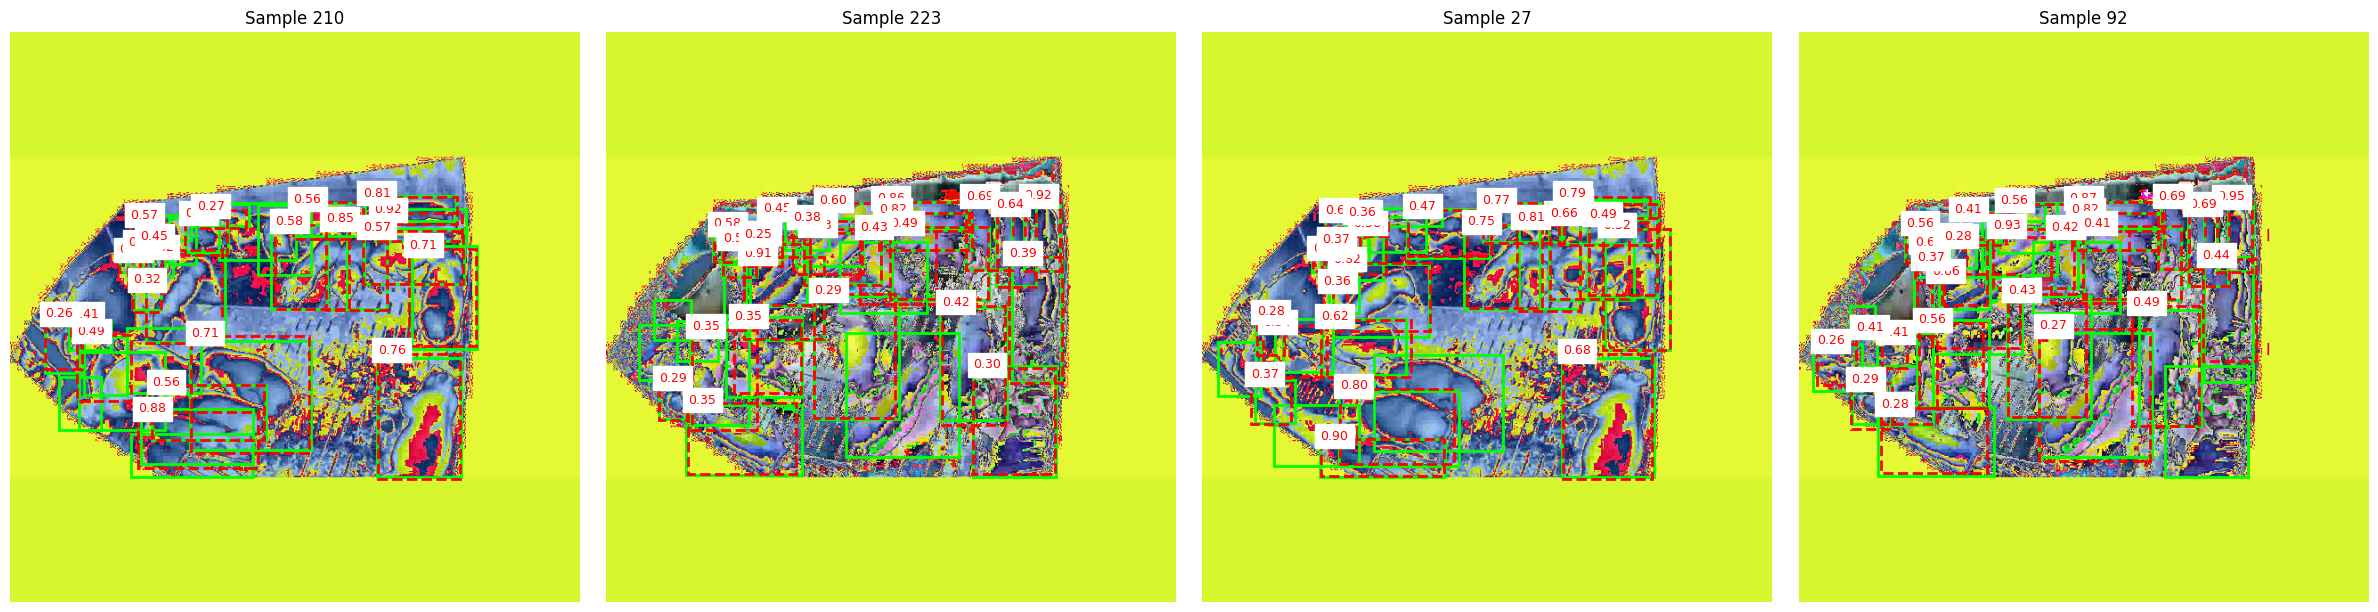

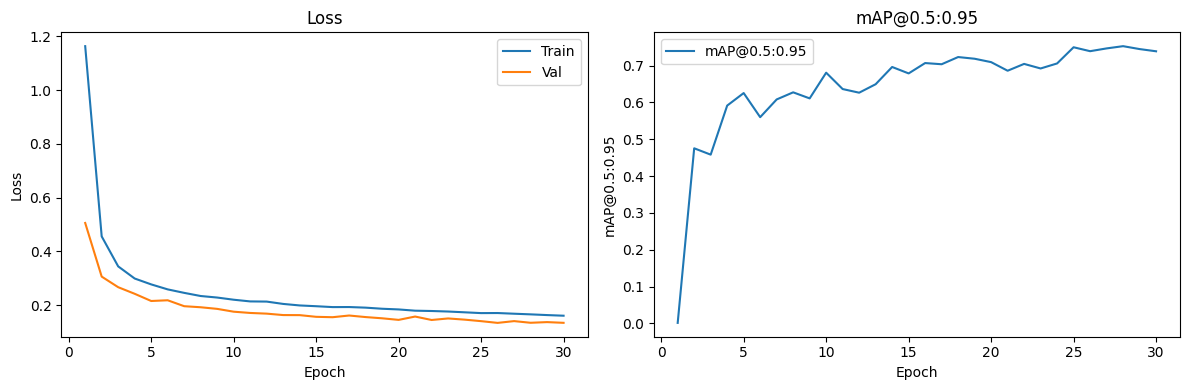

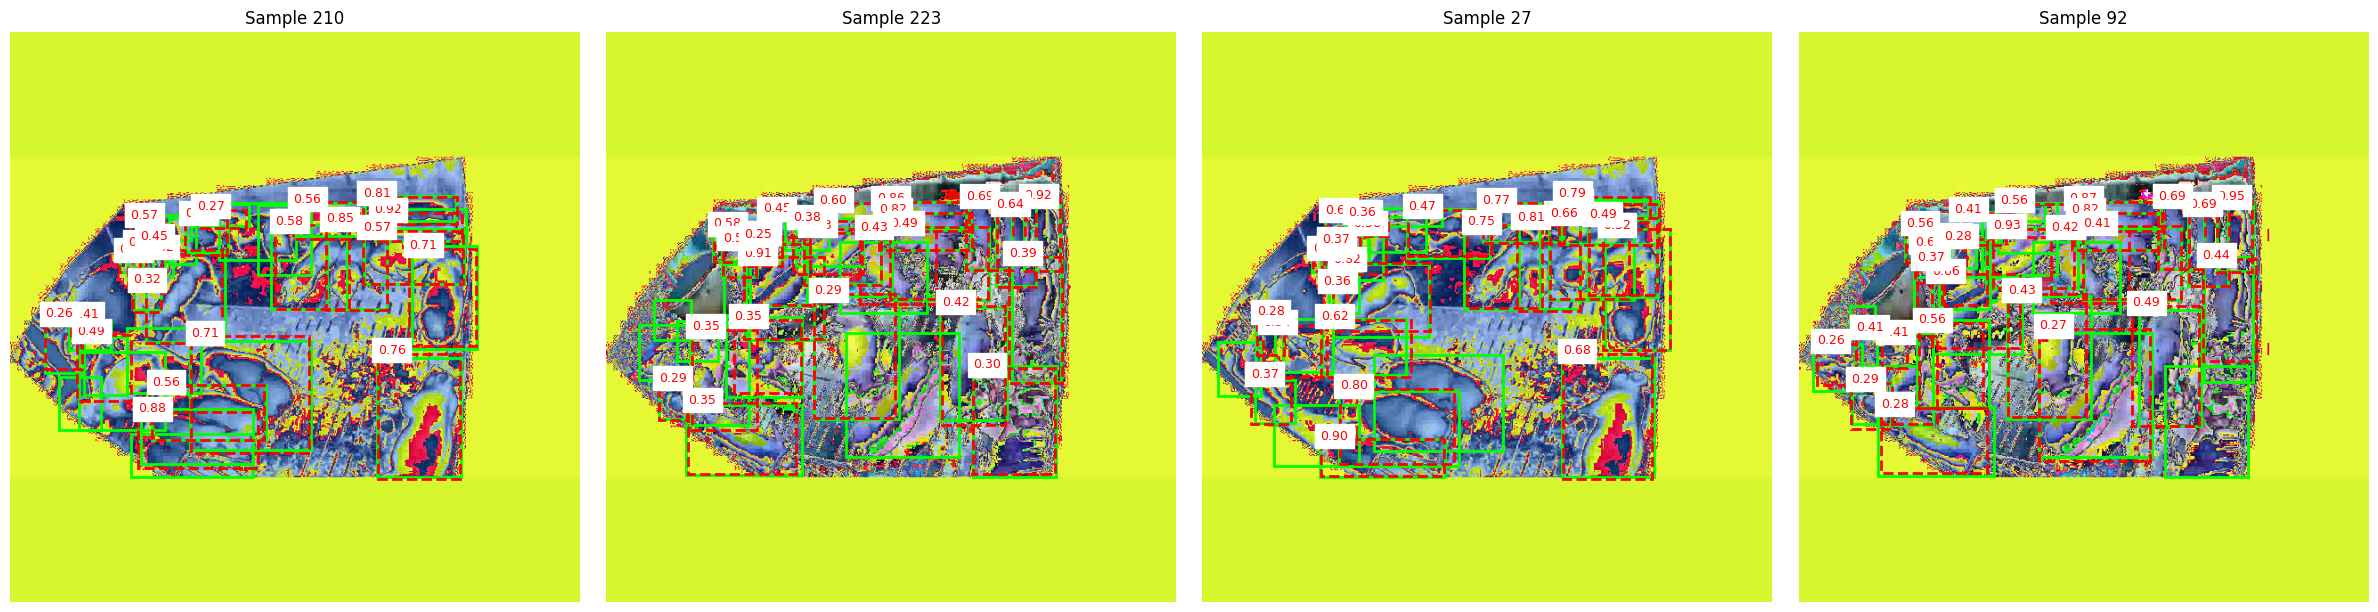

In [14]:
# Plot history and visualize predictions for the latest run
plot_training_history(history)

best_checkpoint = RUN_DIR / "best.pth"
if best_checkpoint.exists():
    state = torch.load(best_checkpoint, map_location=DEVICE)
    model.load_state_dict(state["model_state"])
    print(f"Loaded best checkpoint from {best_checkpoint} for visualization.")
else:
    print("Best checkpoint not found; using current weights for visualization.")

visualize_predictions(
    model,
    val_dataset,
    num_images=4,
    conf_thr=CONF_THRESHOLD,
    iou_threshold=NMS_IOU_THRESHOLD,
)


## Inference

In [19]:
def _load_image_as_tensor(image):
    if isinstance(image, (str, Path)):
        image = Image.open(image).convert("RGB")
    if isinstance(image, Image.Image):
        image = np.array(image)
    tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    return tensor


@torch.no_grad()
def run_inference(model, image, conf_threshold: float = CONF_THRESHOLD, iou_threshold: float = NMS_IOU_THRESHOLD, max_detections: int | None = None):
    model.eval()
    image_tensor = _load_image_as_tensor(image).unsqueeze(0).to(DEVICE)
    cls_preds, obj_preds, box_preds, grids = model(image_tensor)
    detections = model.head.decode(cls_preds, obj_preds, box_preds, grids, conf_thr=conf_threshold, iou_thr=iou_threshold)[0]

    boxes_xyxy = detections["boxes"]
    scores = detections["scores"]
    labels = detections["labels"]

    if max_detections is not None and len(scores) > max_detections:
        keep = np.argsort(scores)[::-1][:max_detections]
        boxes_xyxy = boxes_xyxy[keep]
        scores = scores[keep]
        labels = labels[keep]

    boxes_ltwh = np.array([xyxy_to_ltwh(box) for box in boxes_xyxy], dtype=np.float32)
    return {
        "boxes_ltwh": boxes_ltwh,
        "boxes_xyxy": boxes_xyxy,
        "scores": scores,
        "labels": labels,
    }


def format_detections_for_submission(detections, class_id: int = 0):
    boxes = detections["boxes_ltwh"]
    scores = detections["scores"]
    if boxes.size == 0:
        return ""
    parts = [
        f"{score:.6f} {left:.2f} {top:.2f} {width:.2f} {height:.2f} {class_id}"
        for score, (left, top, width, height) in zip(scores, boxes)
    ]
    return " ".join(parts)


@torch.no_grad()
def run_inference_on_directory(
    model,
    image_dir: Path,
    output_csv: Path | None = None,
    checkpoint_path: Path | None = None,
    conf_threshold: float = CONF_THRESHOLD,
    iou_threshold: float = NMS_IOU_THRESHOLD,
    max_detections: int | None = None,
):
    image_dir = Path(image_dir)
    files = sorted(image_dir.glob("*.jpg"))
    progress_bar = None
    if len(files) > 0:
        progress_bar = _create_progress("Inference", len(files))
        progress_bar.start()
        task = progress_bar.add_task("infer", total=len(files))

    if checkpoint_path is not None and checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(state["model_state"])
        print(f"Loaded checkpoint: epoch={state.get('epoch')}, best_metric={state.get('best_metric')}")

    rows = []
    for path in files:
        detections = run_inference(
            model,
            path,
            conf_threshold=conf_threshold,
            iou_threshold=iou_threshold,
            max_detections=max_detections,
        )
        image_id = path.stem.lstrip("0") or "0"
        prediction_string = format_detections_for_submission(detections)
        rows.append((image_id, prediction_string))
        if progress_bar is not None:
            progress_bar.update(task, advance=1)

    if progress_bar is not None:
        progress_bar.stop()

    if output_csv is not None:
        output_csv = Path(output_csv)
        output_csv.parent.mkdir(parents=True, exist_ok=True)
        with open(output_csv, "w") as fp:
            fp.write("Image_ID,PredictionString\n")
            for image_id, pred in rows:
                fp.write(f"{image_id},{pred}\n")
        print(f"Saved predictions to {output_csv}")

    return rows


# Run inference on test images and save results to CSV
run_inference_on_directory(
    model,
    image_dir=TEST_IMAGES_DIR,
    output_csv=RUN_DIR / "predictions.csv",
    checkpoint_path=RUN_DIR / "best.pth",
    conf_threshold=0.001,
    iou_threshold=0.7,
    max_detections=100,
)


Output()

Loaded checkpoint: epoch=28, best_metric=0.7527490025447252

Saved predictions to artifacts/pig_detection_yolov8/20251010-172940/predictions.csv


[('1',
  '0.309839 223.64 191.62 74.23 158.67 0 0.174444 175.64 60.02 136.59 63.66 0 0.103657 91.92 238.76 145.01 83.17 0 0.101529 296.77 131.07 141.93 82.76 0 0.080670 90.60 276.20 151.52 70.69 0 0.079545 105.35 227.41 100.69 44.46 0 0.076501 137.91 3.62 138.79 33.74 0 0.073904 627.82 334.68 12.10 23.85 0 0.070498 66.22 194.28 163.84 68.30 0 0.050967 101.16 97.66 143.34 79.28 0 0.050822 631.59 177.18 7.63 38.81 0 0.050815 615.46 334.85 23.64 23.75 0 0.050525 631.98 294.49 7.06 39.51 0 0.047416 81.17 39.30 102.50 64.69 0 0.046559 617.78 177.18 20.45 38.57 0 0.046266 616.47 323.28 22.54 34.30 0 0.046086 107.12 243.47 121.21 43.65 0 0.045077 110.85 220.86 109.11 54.80 0 0.043737 66.71 181.08 156.50 66.46 0 0.042316 80.30 0.21 111.31 19.64 0 0.041207 47.05 239.37 138.59 84.17 0 0.038165 152.03 0.61 100.43 19.30 0 0.036710 629.74 321.69 9.73 34.69 0 0.034282 304.96 132.58 109.94 43.41 0 0.033359 70.07 74.36 62.12 88.43 0 0.032710 87.04 295.73 160.76 62.62 0 0.032594 201.85 0.41 89.98 17.87

Loaded checkpoint from artifacts/pig_detection_yolov8/20251010-172940/best.pth


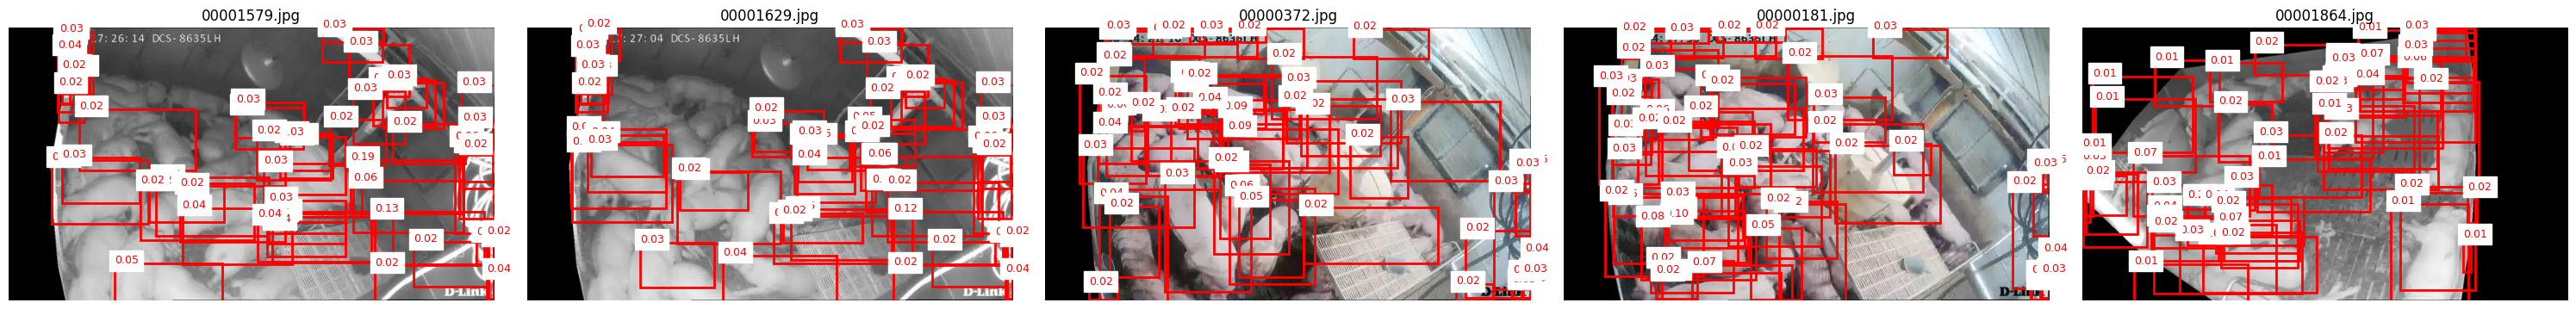

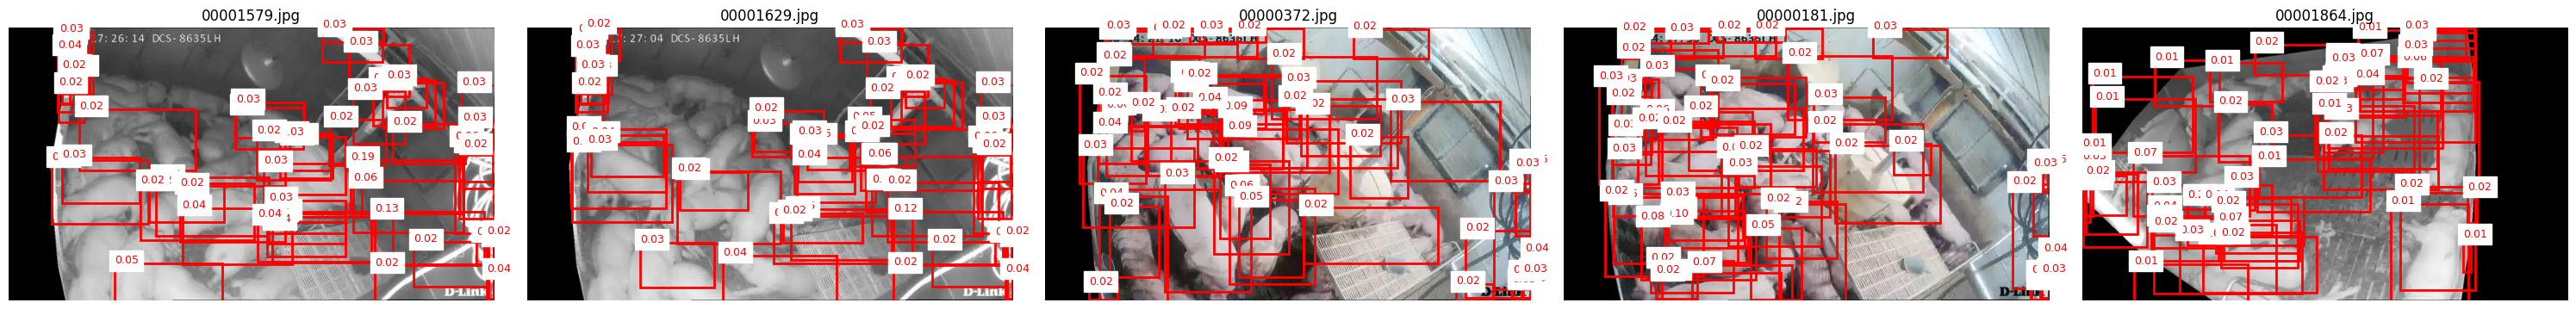

In [20]:
@torch.no_grad()
def visualize_random_predictions(
    model,
    image_dir: Path,
    num_images: int = 5,
    checkpoint_path: Path | None = None,
    conf_threshold: float = CONF_THRESHOLD,
    iou_threshold: float = NMS_IOU_THRESHOLD,
    max_detections: int | None = 50,
):
    image_dir = Path(image_dir)
    image_paths = sorted(image_dir.glob("*.jpg"))
    if not image_paths:
        raise ValueError(f"No images found in {image_dir}")

    sample_paths = random.sample(image_paths, min(num_images, len(image_paths)))

    if checkpoint_path is not None and checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(state["model_state"])
        print(f"Loaded checkpoint from {checkpoint_path}")

    model.eval()
    fig, axes = plt.subplots(1, len(sample_paths), figsize=(6 * len(sample_paths), 6))
    if len(sample_paths) == 1:
        axes = [axes]

    for ax, path in zip(axes, sample_paths):
        detections = run_inference(
            model,
            path,
            conf_threshold=conf_threshold,
            iou_threshold=iou_threshold,
            max_detections=max_detections,
        )
        image = Image.open(path).convert("RGB")
        ax.imshow(image)
        ax.set_title(path.name)
        ax.axis("off")

        boxes_xyxy = detections["boxes_xyxy"]
        scores = detections["scores"]
        for box, score in zip(boxes_xyxy, scores):
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, y1, f"{score:.2f}", color="red", fontsize=9, backgroundcolor="white")

    plt.tight_layout()
    plt.show()
    return fig


# Visualize random predictions from the trained model
visualize_random_predictions(
    model,
    image_dir=TEST_IMAGES_DIR,
    num_images=5,
    checkpoint_path=OUTPUT_DIR / "best.pth",
    conf_threshold=0.001,
    iou_threshold=0.7,
    max_detections=50,
)


## Next Steps

- Implement a stronger label assignment strategy (e.g., TaskAligned, SimOTA) to replace the simplified loss placeholders.
- Add NMS and per-class decoding during inference for submission-ready outputs.
- Integrate mixed-precision evaluation/inference toggles and experiment tracking as needed.